In [119]:
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy as gp
import networkx as nx
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 8
sc.set_figure_params(dpi=100, dpi_save=600, frameon=False, figsize=(5,5))
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
%config InlineBackend.figure_format = 'retina'

In [ ]:
adata = sc.read_h5ad('./Results/05_noci.h5ad')
adata.X = adata.layers['log_norm'].copy()

In [121]:
adata.obs.Time = adata.obs.Time.cat.reorder_categories(['0day','0.25day','0.5day','1day','1.5day','2day','3day','7day','14day','28day'])

In [122]:
adata = adata[adata.obs.Conditions != 'Sham'].copy()

In [123]:
adata = adata[(adata.obs.Time.isin(['0day','14day'])) & (adata.obs.Conditions.isin(['Naive','Crush']))].copy()

In [124]:
adata.obs.Time = adata.obs.Time.cat.remove_unused_categories()
adata.obs.Conditions = adata.obs.Conditions.cat.remove_unused_categories()

# DEA of Crush vs Naive Nociceptors

In [125]:
from decoupler import get_pseudobulk
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# create pseudobulk from raw counts
adata.X = adata.layers['counts'].toarray().copy()
pbs_adata = get_pseudobulk(adata, 'donor_id', 'Conditions', min_prop=0.2)

# create DeseqDataSet object and run DE analysis
dds = DeseqDataSet(adata = pbs_adata, design_factors=['Source', 'Sex', 'Conditions'], n_cpus=8, quiet=True)
sc.pp.filter_genes(dds, min_cells = 3)
dds.deseq2()

/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/pydeseq2/dds.py:264: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting dispersions...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 0.88 seconds.

Fitting LFCs...
... done in 0.77 seconds.



In [59]:
stat_res = DeseqStats(dds, contrast=('Conditions', 'Crush', 'Naive'), quiet=True)
stat_res.summary()
de = stat_res.results_df.sort_values('stat', ascending = False)

In [66]:
de_filter = de.dropna().loc[de['padj'] < 0.05].copy()
# de_filter.to_excel('./tables/05_de_crush_vs_naive_noci.xlsx')

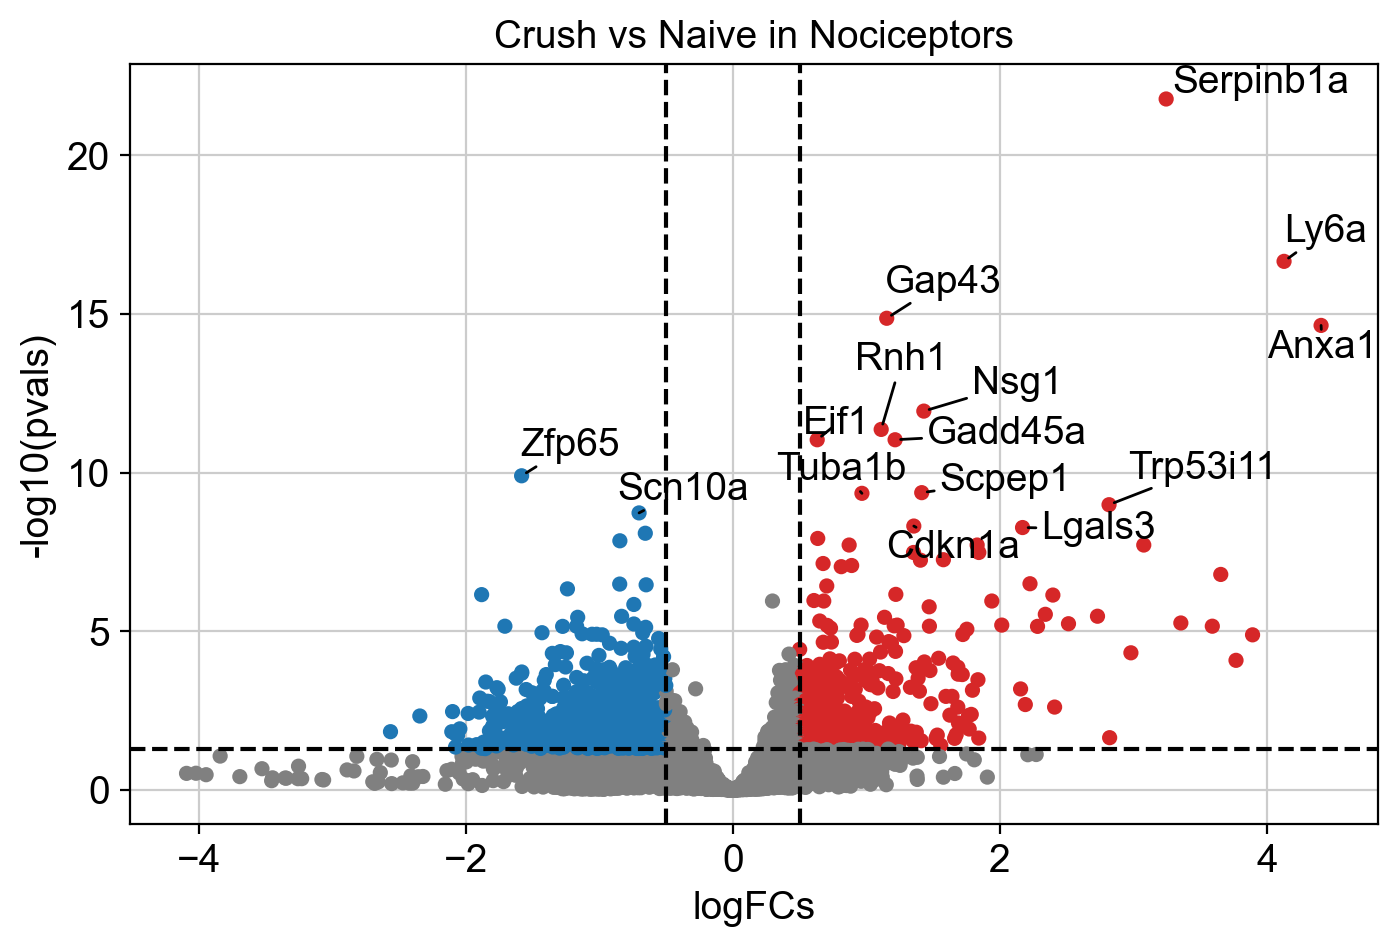

In [96]:
from decoupler import plot_volcano_df
fig,ax = plt.subplots(figsize=(8,5))
plot_volcano_df(de, 'log2FoldChange', 'padj', top=15, ax=ax, lFCs_limit=5.5)
ax.set_title('Crush vs Naive in Nociceptors')
fig.savefig('./figures/DE_Crush_vs_Naive_Nociceptors.pdf', bbox_inches='tight')

In [90]:
import gseapy as gp
from tqdm import tqdm
def get_enrich(df_, n_top=100):
    gset = 'GO_Biological_Process_2023'
    up = df_.sort_values('log2FoldChange', ascending=False).loc[lambda x: x.log2FoldChange > 0].head(n_top).index.tolist()
    down = df_.sort_values('log2FoldChange', ascending=True).loc[lambda x: x.log2FoldChange < 0].head(n_top).index.tolist()
    enr_up = gp.enrichr(up, gene_sets=gset,outdir=None)
    enr_down = gp.enrichr(down, gene_sets=gset,outdir=None)
    enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]
    enr_down.res2d.Term = enr_down.res2d.Term.str.split(" \(GO").str[0]
    enr_up.res2d['UP_DW'] = "UP"
    enr_down.res2d['UP_DW'] = "DOWN"
    enr_res = pd.concat([enr_up.res2d.head(), enr_down.res2d.head()])
    return enr_res

In [111]:
de_filter = de.dropna().loc[de['padj'] < 0.05].copy()

In [ ]:
enr_crush = get_enrich(de_filter, n_top=150)
enr_crush.to_excel('./tables/06_crush_de_GSEA_noci.xlsx')

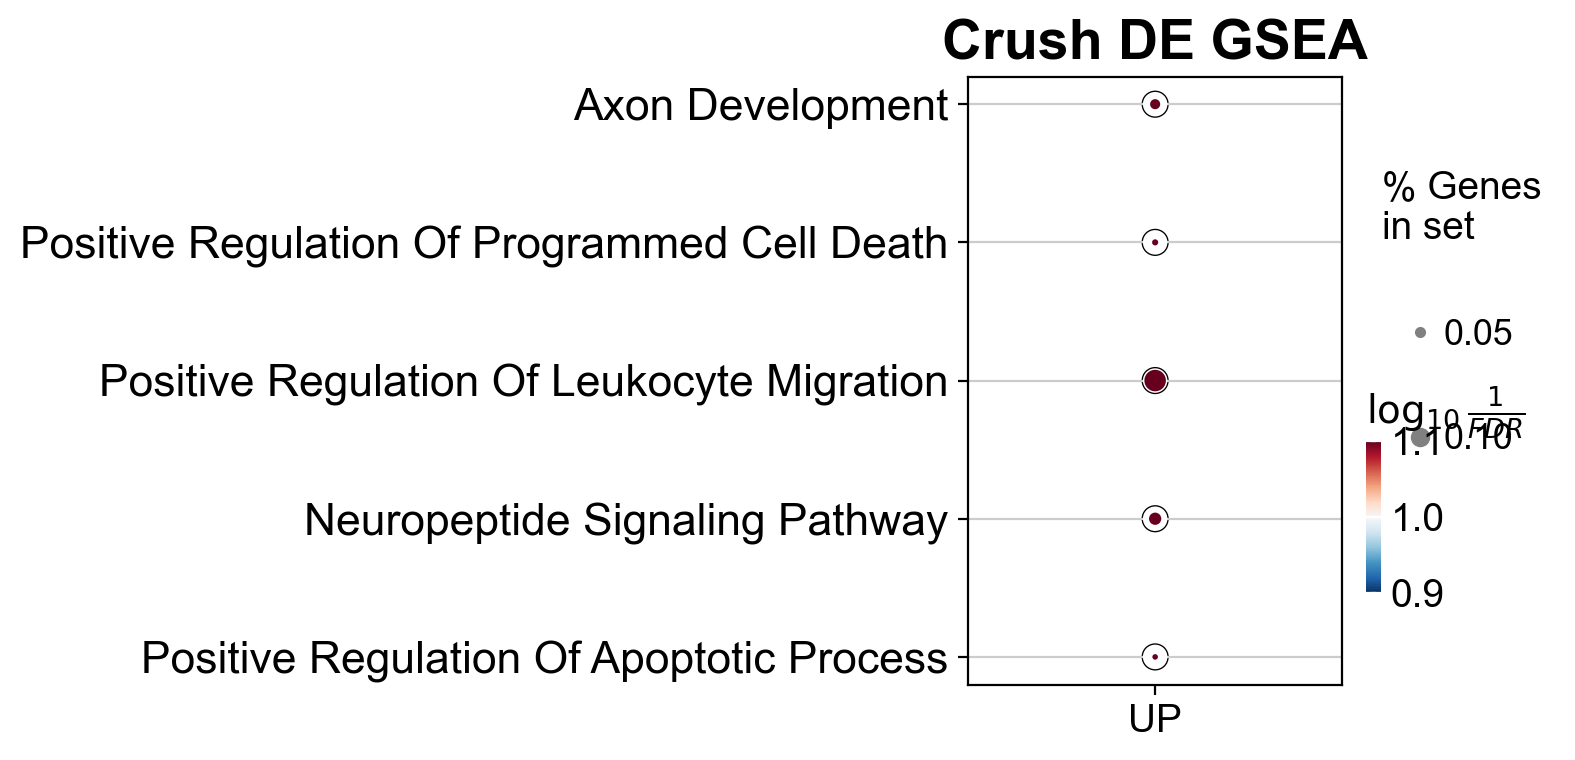

In [ ]:
# display multi-datasets
ax = gp.dotplot(enr_crush,figsize=(3,4),
                x='UP_DW',
                x_order = ["UP","DOWN"],
                title='Crush DE GSEA',
                cmap = 'RdBu_r',
                size=10,
                show_ring=True,
                )
ax.set_xlabel("")
ax.grid(axis='x')
plt.savefig(f'./figures/06_Crush_de_GSEA.pdf', bbox_inches='tight')

# Co-expression analysis of RNAse4

In [ ]:
from tqdm import tqdm
from scipy.sparse import csr_matrix
from statsmodels.stats.multitest import multipletests

def pos_neg(v): # function to determine the sign of the correlation
    if v < 0:
        return "Negative"
    else:
        return "Positive"
        
def adj_p(v): # function to adjust the p-value
    if v == 0:
        return 2.2e-308
    else:
        return v

def test_gene_correlation(adata_:sc.AnnData, gene:str, condition:str = None, layer:str = None, method='spearman', alpha=0.05): # function to test the correlation of a gene with all other genes

    # check if the gene is in the adata
    if condition is None:
        adata_.obs['Condition_'] = 'All'
        condition = 'Condition_'
    
    out = {} # out dictionary
    for Condition in tqdm(adata_.obs[condition].cat.categories, desc=condition):
        
        # subset the adata to have only cells from specific condition & time
        adata_sub = adata_[adata_.obs[condition] == Condition].copy() 
        sc.pp.filter_genes(adata_sub, min_cells=10)
        
        data = adata_sub.X if layer is None else adata_sub.layers[layer].copy()
        
        # convert the sparse matrix to dense matrix
        if isinstance(data, csr_matrix):
            data = data.toarray().astype(np.double)
        
        pre_out = [] # declare the list object to save the correlation output
        for gene_ in tqdm(adata_sub.var_names, desc='Gene'):
            i1 = np.where(adata_sub.var_names == gene)[0][0]
            i2 = np.where(adata_sub.var_names == gene_)[0][0]
            if method == 'spearman':
                res = stats.spearmanr(data[:,i1], data[:,i2])
            elif method == 'pearson':
                res = stats.pearsonr(data[:,i1], data[:,i2])
            else:
                raise ValueError(f"Unsupported method: {method}")
            pre_out.append([gene_, res[0], res[1]])    
            
        out[Condition] = pd.DataFrame(pre_out, columns= ['gene', 'r', 'p'])
        out[Condition][condition] = Condition
        out[Condition]['Test'] = gene

    # concatenate the output
    edit_out = pd.concat(out.values(), axis=0)
    edit_out.dropna(inplace=True)
    edit_out = edit_out[edit_out.gene != gene].reset_index(drop=True) # remove the query gene itself
    edit_out['new_p'] = edit_out.p.map(lambda x: adj_p(x))
    edit_out['q_val'] = multipletests(edit_out.new_p, alpha=alpha, method='fdr_bh')[1] # adjust the p-value for multiple testing
    edit_out['-log10_p'] = -np.log10(edit_out.new_p)
    edit_out['Cor'] = edit_out.r.map(lambda x: pos_neg(x)).astype('category')
    edit_out = edit_out[edit_out.q_val < 0.05].sort_values('q_val').reset_index(drop=True) # filter the significant results and sort based on the adjusted p-value

    return edit_out

In [ ]:
corr_out = test_gene_correlation(adata, 'Rnase4', condition='Conditions', layer='log_norm', method='spearman')
corr_out.to_excel('./tables/06_rnase4_correlation.xlsx', index=False)

Conditions: 100%|██████████| 2/2 [01:30<00:00, 45.30s/it]


In [142]:
timepoint_data = {tp: corr_out[corr_out.Conditions == tp].reset_index(drop=True) for tp in adata.obs.Conditions.cat.categories}

## GSEA of RNAse4 Network

In [ ]:
import gseapy as gp

# function to get the GSEA enrichment for the top genes
def get_enrich(df, n_top=100):
    gset = 'GO_Biological_Process_2023'
    up = df.sort_values('r', ascending=False).loc[lambda x: x.r > 0].gene.head(n_top)
    down = df.sort_values('r', ascending=True).loc[lambda x: x.r < 0].gene.head(n_top)
    enr_up = gp.enrichr(up, gene_sets=gset,outdir=None)
    enr_down = gp.enrichr(down, gene_sets=gset,outdir=None)
    enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]
    enr_down.res2d.Term = enr_down.res2d.Term.str.split(" \(GO").str[0]
    enr_up.res2d['UP_DW'] = "UP"
    enr_down.res2d['UP_DW'] = "DOWN"
    enr_res = pd.concat([enr_up.res2d.head(), enr_down.res2d.head()])
    return enr_res

In [135]:
enr_res = {tp: get_enrich(corr_df) for tp, corr_df in tqdm(timepoint_data.items(), desc='Enrichment', total=len(timepoint_data))}

Enrichment: 100%|██████████| 2/2 [00:10<00:00,  5.17s/it]


In [136]:
enr_res['Crush']['Conditions'] = 'Crush'
enr_res['Naive']['Conditions'] = 'Naive'

In [ ]:
enr_res_df = pd.concat(enr_res.values(), axis=0)
enr_res_df.to_csv('./tables/06_rnase4_enrichment.csv', index=False)

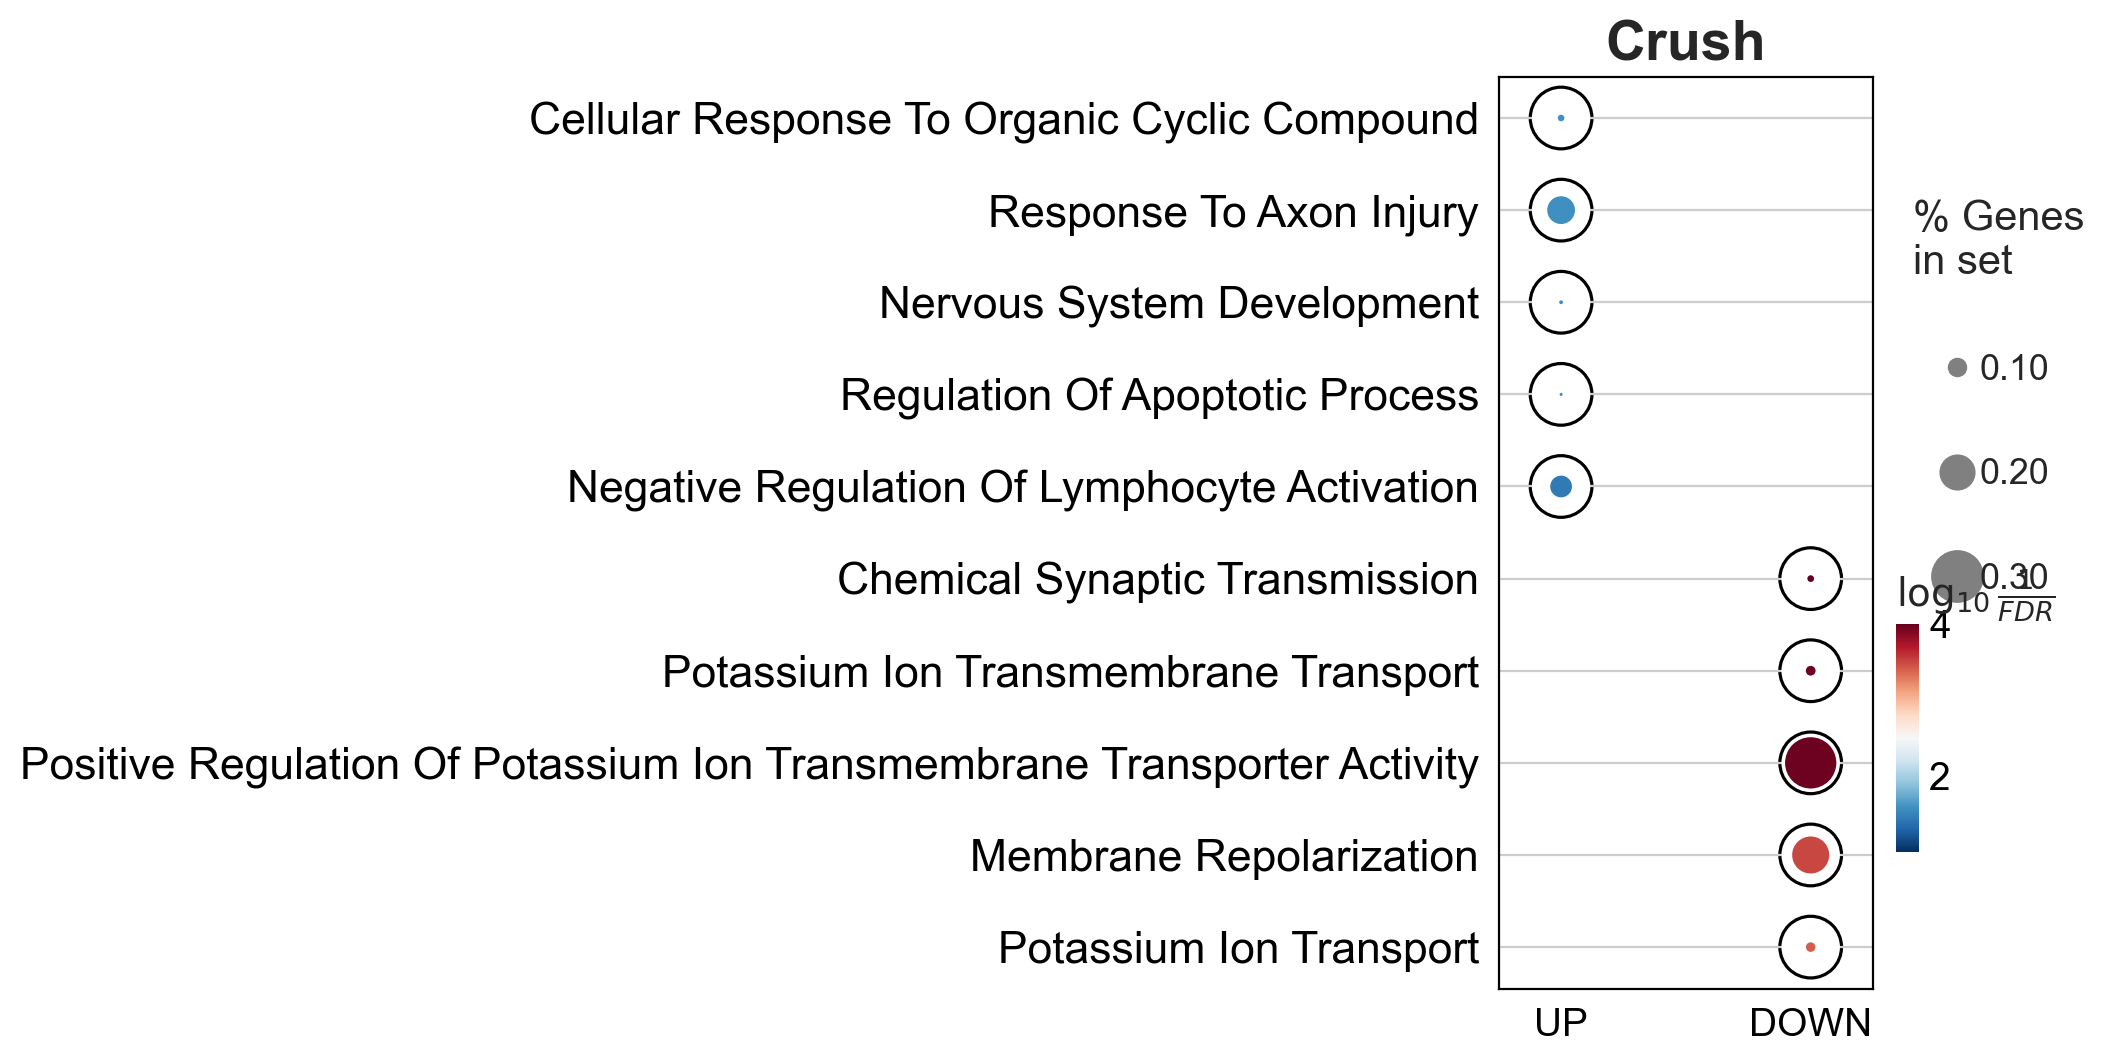

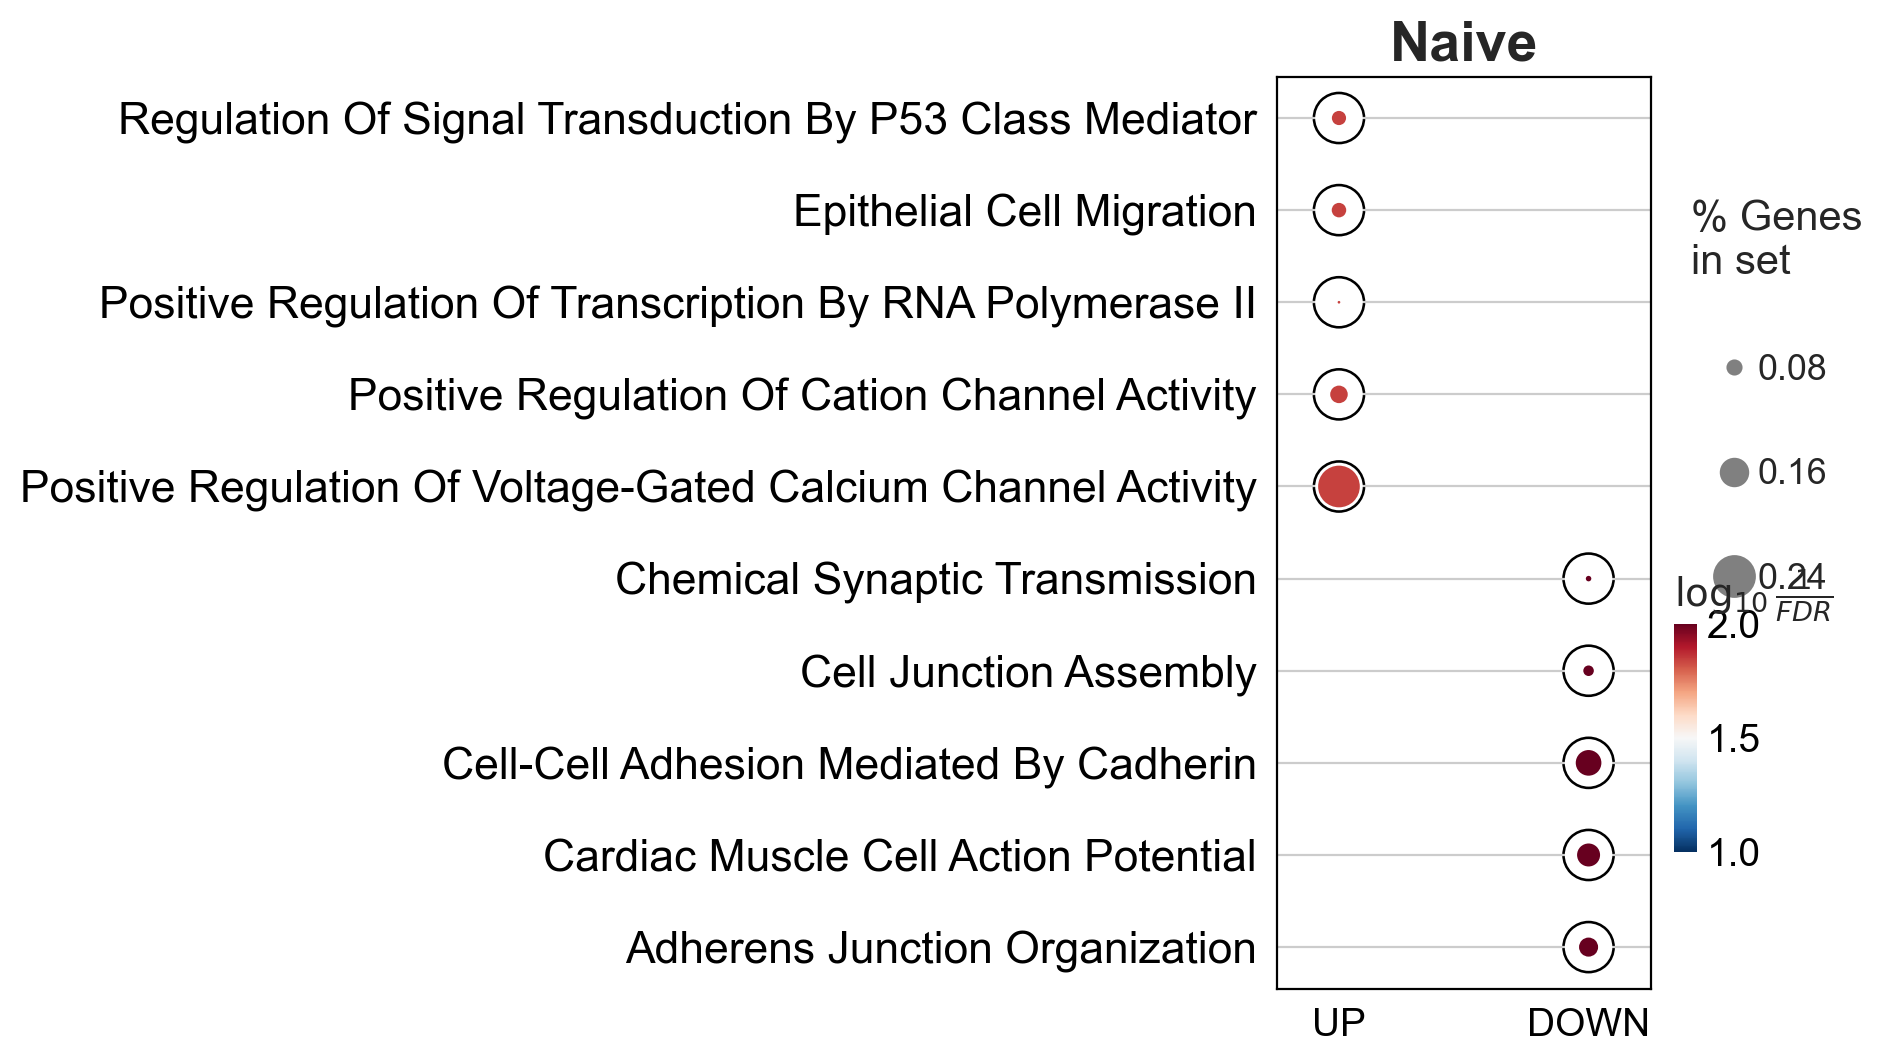

In [ ]:
# display multi-datasets
for k,v in enr_res.items():
    ax = gp.dotplot(v,figsize=(3,6),
                    x='UP_DW',
                    x_order = ["UP","DOWN"],
                    title=k,
                    cmap = 'RdBu_r',
                    size=10,
                    show_ring=True,
                    )
    ax.set_xlabel("")
    ax.grid(axis='x')
    plt.savefig(f'./figures/06_Rnase4_{k}_enrichment.pdf', bbox_inches='tight')